# **<font color=white> 10.AdaBoost Code 실습**

[목적]
  - Bias를 낮추기위한 Boosting의 초기 모델 AdaBoost 실습 및 해석

[Process]
  - Define X's & Y
  - Split Train & Valid dataset
  - Modeling
  - Model 해석

AdaBoost의 기본 아이디어는 다음과 같습니다:

- 약한 학습기: AdaBoost는 약한 학습기(예: 깊이가 얕은 의사결정 나무)를 사용합니다. 약한 학습기는 무작위 추측보다는 약간 낫다고 할 수 있는 학습기를 의미합니다.

- 가중치 부여: 학습 데이터 각각에 초기 가중치를 동일하게 부여합니다. 이후 각 반복에서 학습기는 데이터의 가중치를 고려하여 학습하게 됩니다.

- 반복적 학습: AdaBoost는 여러 번의 반복을 통해 학습기를 학습시킵니다. 각 반복마다 데이터 포인트의 가중치가 조정되어, 이전에 잘못 분류된 데이터 포인트에 더 많은 주목을 기울일 수 있게 됩니다.

- 가중치 업데이트: 학습기가 학습을 마치면, 잘못 분류된 데이터 포인트의 가중치는 증가시키고, 올바르게 분류된 데이터의 가중치는 감소시킵니다.

- 앙상블 예측: 모든 학습기가 학습을 마치면, AdaBoost는 각 학습기의 예측을 결합하여 최종 예측을 생성합니다. 이 때 각 학습기의 예측에는 그 학습기의 성능에 따라 다른 가중치가 부여됩니다.

AdaBoost의 장점:

- 간단한 알고리즘에도 높은 성능을 달성할 수 있습니다.
- 오버피팅(과적합)에 상대적으로 강합니다.
- 별도의 파라미터 조정이 거의 필요하지 않습니다.

AdaBoost의 단점:

- 잡음(noise)이 많은 데이터나 이상치(outliers)에 민감할 수 있습니다.
- 실행 시간이 길 수 있습니다.

마지막으로, AdaBoost는 다양한 알고리즘과 함께 사용될 수 있지만, 주로 의사결정 나무와 함께 사용되며, 특히 깊이가 1인 나무(즉, 'stump')를 사용하는 것이 일반적입니다.



In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


In [4]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [5]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[AdaBoost Parameters]
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
  - n_estimators : # of Tree
  - learning_rate : learning_rate과 n_estimator와 Trade-off 관계가 있음
    - Weight applied to each classifier at each boosting iteration

In [6]:
# AdaBoost Hyperparameter
estimators = [70, 90, 100]
learning = [0.01, 0.03, 0.05, 0.1, 0.5]

# Modeling
save_est = []
save_lr = []
f1_score_ = []

cnt = 0
for est in estimators:
    for lr in learning:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print("Number of Estimators : {}, Learning Rate : {}".format(est, lr))

        model = AdaBoostClassifier(n_estimators=est, learning_rate=lr, random_state=119)
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
        print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
        print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_lr.append(lr)
        f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 70, Learning Rate : 0.01
Train Confusion Matrix
[[188  53]
 [  9 122]]
Train Acc : 0.8333333333333334
Train F1-Score : 0.7973856209150328
Test Confusion Matrix
[[81 29]
 [ 1 49]]
TesT Acc : 0.8125
Test F1-Score : 0.765625
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 70, Learning Rate : 0.03
Train Confusion Matrix
[[199  42]
 [ 11 120]]
Train Acc : 0.8575268817204301
Train F1-Score : 0.8191126279863481
Test Confusion Matrix
[[84 26]
 [ 2 48]]
TesT Acc : 0.825
Test F1-Score : 0.7741935483870968
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 70, Learning Rate : 0.05
Train Confusion Matrix
[[200  41]
 [ 10 121]]
Train Acc : 0.8629032258064516
Train F1-Score : 0.8259385665529011
Test Confusion Matrix


In [7]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}".format(np.argmax(f1_score_),
                                                                                                    f1_score_[np.argmax(f1_score_)],
                                                                                                    save_est[np.argmax(f1_score_)],
                                                                                                    save_lr[np.argmax(f1_score_)]))

>>> 4 <<<
Best Test f1-score : 0.7899159663865546
Best n_estimators : 70
Best Learning Rate : 0.5


[주의]

  - 현재는 모델을 Parameter Tuning을 하면서 모델을 저정하지 않고 있음
  - 나중에 Training 시간이 매우 오래 걸리는 알고리즘이면 Parameter Tuning을 하면서 모델을 저장해야함

In [8]:
best_model = AdaBoostClassifier(n_estimators=save_est[np.argmax(f1_score_)], learning_rate=save_lr[np.argmax(f1_score_)], random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[231  10]
 [  8 123]]
Train Acc : 0.9516129032258065
Train F1-Score : 0.9318181818181818
Test Confusion Matrix
[[88 22]
 [ 3 47]]
TesT Acc : 0.84375
Test F1-Score : 0.7899159663865546


In [10]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.171429    event
1   0.128571    cd420
2   0.114286  preanti
3   0.100000     cd40
4   0.085714     wtkg
5   0.085714        r
6   0.085714    cd820
7   0.071429     cd80
8   0.071429    cd496
9   0.057143      age
10  0.028571     race
11  0.000000   zprior
12  0.000000      z30
13  0.000000  symptom
14  0.000000    strat
15  0.000000     str2
16  0.000000   oprior
17  0.000000   karnof
18  0.000000     homo
19  0.000000     hemo
20  0.000000   gender
21  0.000000    drugs


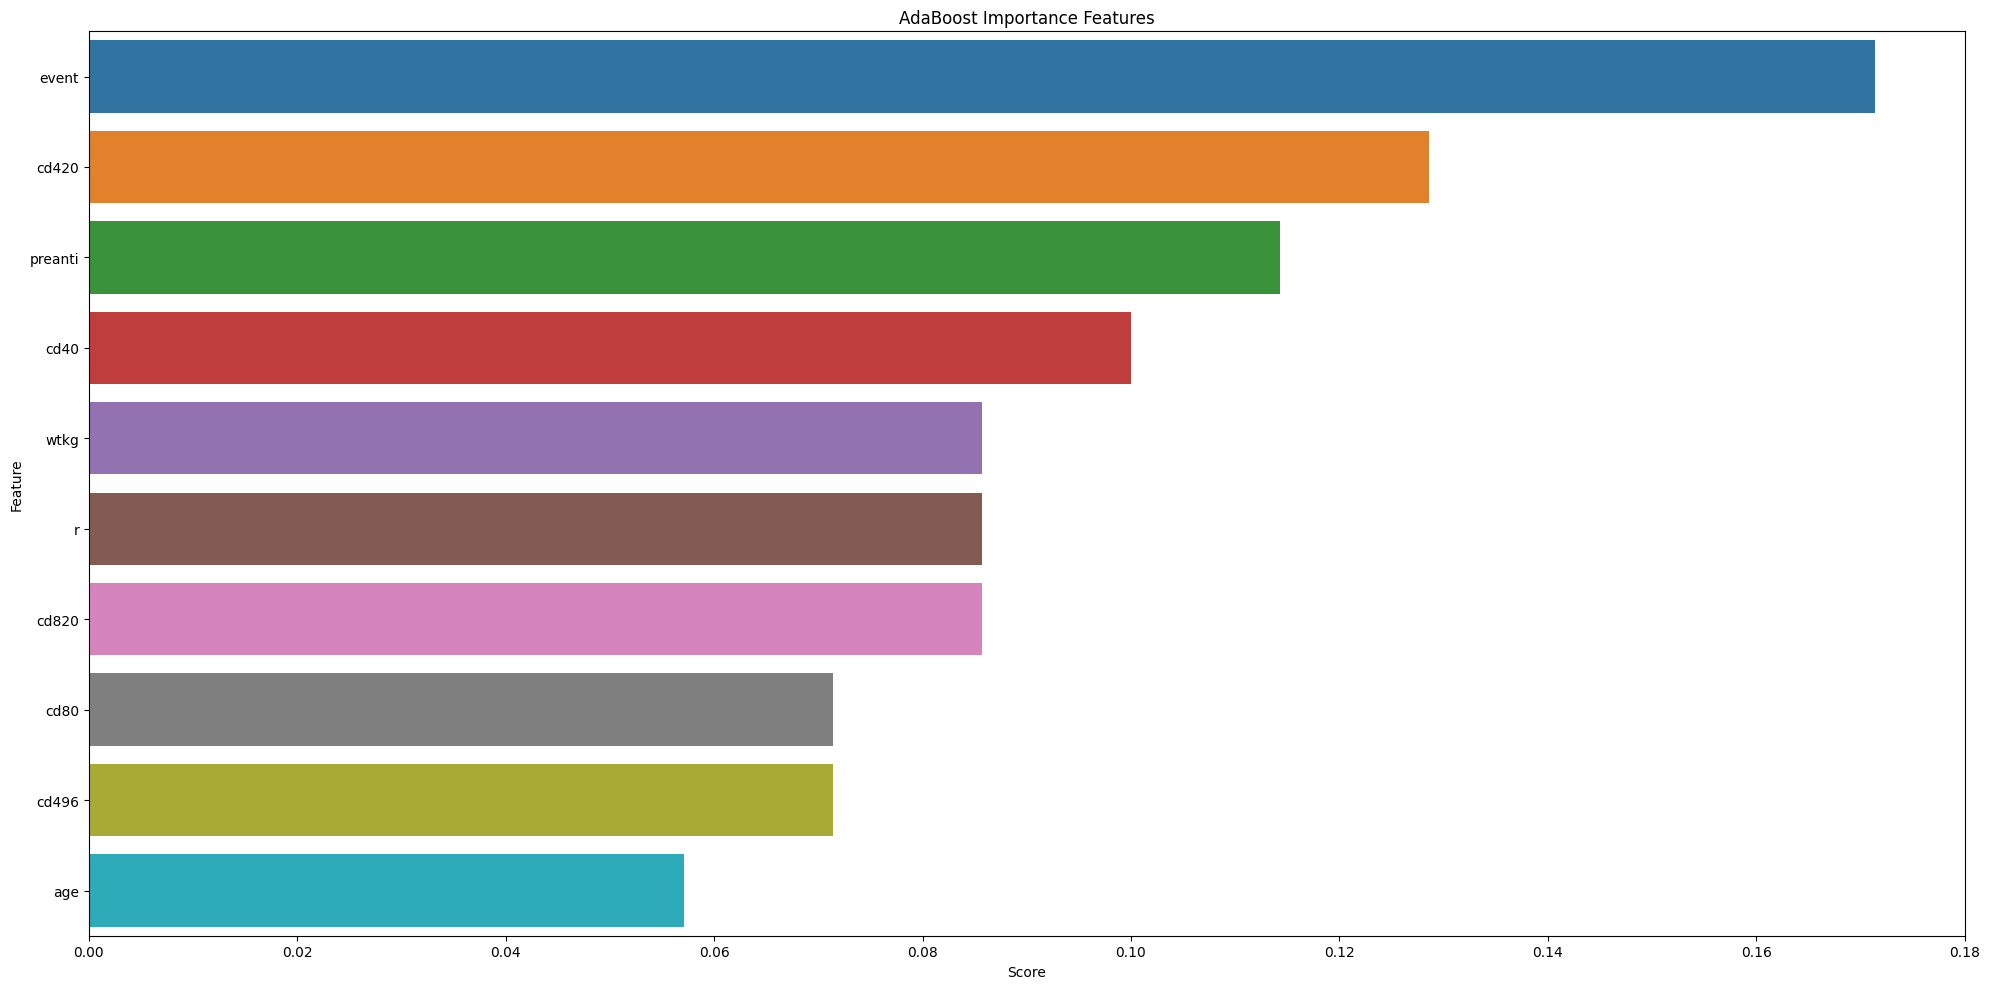

In [11]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('AdaBoost Importance Features')
plt.tight_layout()
plt.show()